The electronic report will be a Jupyter notebook in which the code cells will download a dataset (chosen from the list of options below) from the web, reproducibly and sensibly wrangle and clean, summarize and visualize the data, as well as appropriately answer a predictive question. Markdown cells will be used throughout the document to narrate the analysis to communicates the question asked, methods used and the conclusion reached.

For this project, you will need to formulate and answer a predictive question about a dataset of your choice using either classification or regression. 

Note that you are not allowed to pick a dataset that we have already used during lecture or in one of the assignments.

In [11]:
library(tidyverse)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/



In [3]:
boat_data <- read_csv("data/train.csv")
boat_data

Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NA,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NA,S


In [4]:
#getting rid of PassengerId,Name, Embarked,Ticket and Cabin:
boat_data_selected <- boat_data |>
    select(-PassengerId, -Name, -Embarked, -Ticket, -Cabin)
boat_data_selected


Survived,Pclass,Sex,Age,SibSp,Parch,Fare
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,male,22,1,0,7.2500
1,1,female,38,1,0,71.2833
1,3,female,26,0,0,7.9250
1,1,female,35,1,0,53.1000
0,3,male,35,0,0,8.0500
0,3,male,NA,0,0,8.4583
0,1,male,54,0,0,51.8625
0,3,male,2,3,1,21.0750
1,3,female,27,0,2,11.1333


In [5]:
#renaming columns

colnames(boat_data_selected) = c("Survived?", "Passenger_Class", "Sex", "Age", "Number0fSiblings", "NumberofParents/children", "Fare")

In [6]:
#adding a column for sex in binary(for it to work with the knn model)

boat_data_binary <- boat_data_selected |>
    mutate(sex_binary = ifelse(Sex == "male", 1, ifelse(Sex == "female", 0, NA)))
nrow(boat_data_binary)
boat_data_binary

[1] 891

Survived?,Passenger_Class,Sex,Age,Number0fSiblings,NumberofParents/children,Fare,sex_binary
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,male,22,1,0,7.2500,1
1,1,female,38,1,0,71.2833,0
1,3,female,26,0,0,7.9250,0
1,1,female,35,1,0,53.1000,0
0,3,male,35,0,0,8.0500,1
0,3,male,NA,0,0,8.4583,1
0,1,male,54,0,0,51.8625,1
0,3,male,2,3,1,21.0750,1
1,3,female,27,0,2,11.1333,0


In [7]:
#removing the columns with NA values for age.
#we see we only loose about 20 percent of 

boat_data_NA <- boat_data_binary |>
    filter(!is.na(Age))
nrow(boat_data_NA)
boat_data_NA

[1] 714

Survived?,Passenger_Class,Sex,Age,Number0fSiblings,NumberofParents/children,Fare,sex_binary
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,male,22,1,0,7.2500,1
1,1,female,38,1,0,71.2833,0
1,3,female,26,0,0,7.9250,0
1,1,female,35,1,0,53.1000,0
0,3,male,35,0,0,8.0500,1
0,1,male,54,0,0,51.8625,1
0,3,male,2,3,1,21.0750,1
1,3,female,27,0,2,11.1333,0
1,2,female,14,1,0,30.0708,0


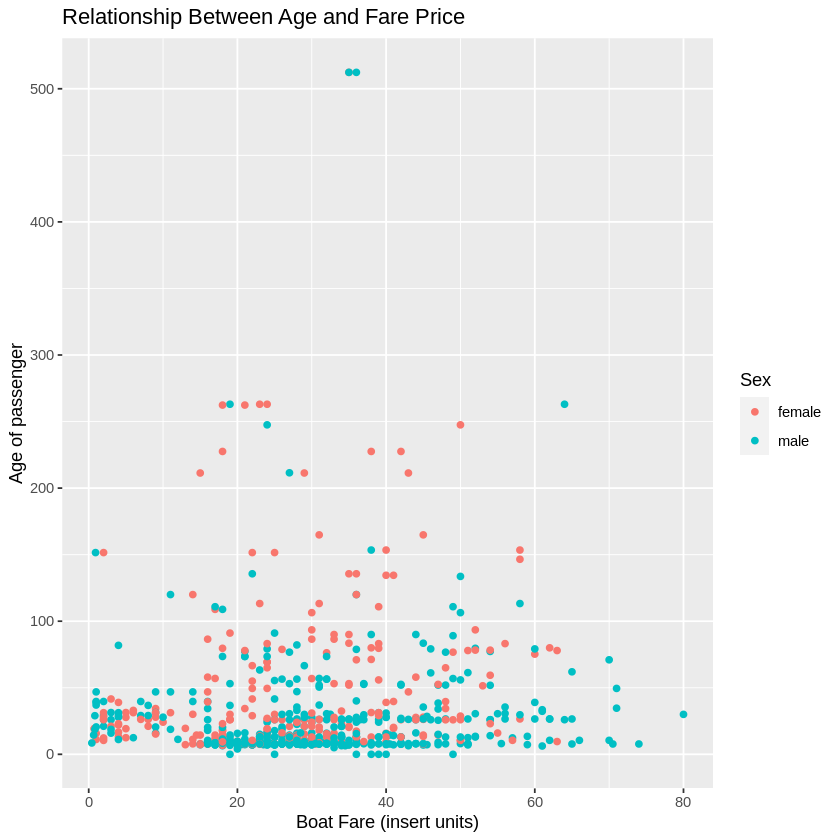

In [13]:
fare_plot <- boat_data_NA |> ggplot(aes(x = Age, y = Fare, colour = Sex)) + geom_point() + 
    labs(x = "Boat Fare (insert units)", y = "Age of passenger", colour = "Sex") +
    ggtitle("Relationship Between Age and Fare Price")
fare_plot

Survived,Passenger_Class,Sex,Age,Number0fSiblings,NumberofParents/children,Fare,sex_binary,Survived_char
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,3,male,22,1,0,7.2500,1,Did not survive
1,1,female,38,1,0,71.2833,0,Survived
1,3,female,26,0,0,7.9250,0,Survived
1,1,female,35,1,0,53.1000,0,Survived
0,3,male,35,0,0,8.0500,1,Did not survive
0,1,male,54,0,0,51.8625,1,Did not survive
0,3,male,2,3,1,21.0750,1,Did not survive
1,3,female,27,0,2,11.1333,0,Survived
1,2,female,14,1,0,30.0708,0,Survived


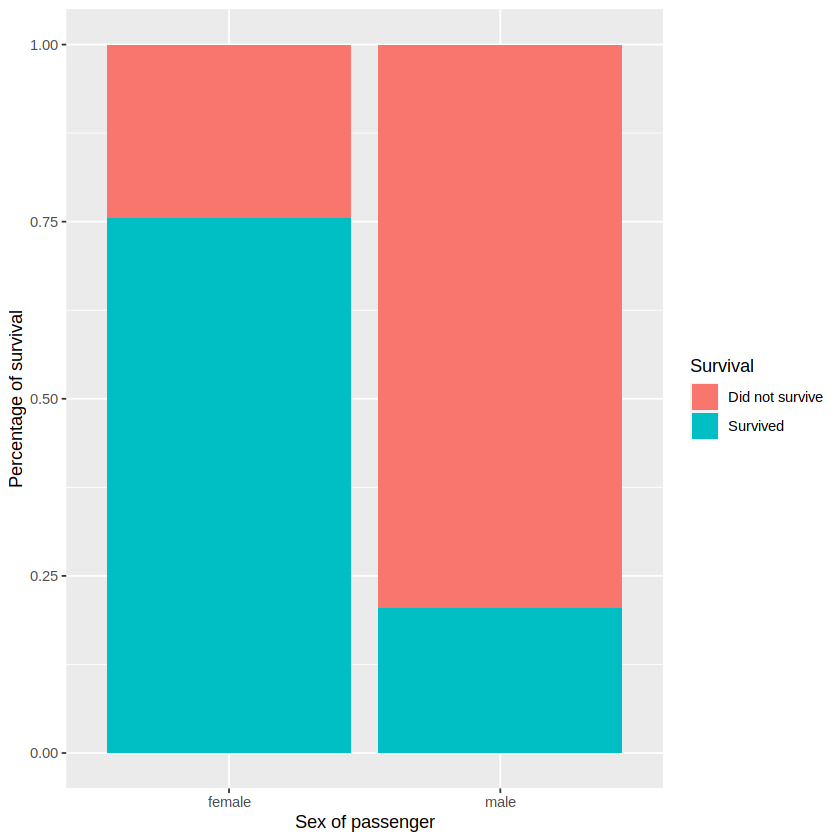

In [33]:
#bar graph to display how many people survived vs how many did not.(percentage of survival)

temp_data_graph <- boat_data_NA |>
    mutate(Survived_char = ifelse(Survived == 1, "Survived", ifelse(Survived == 0, "Did not survive", NA)))

temp_data_graph

survival_bar_plot <- ggplot(temp_data_graph, aes(x = Sex, fill = as_factor(Survived_char))) +
    geom_bar(position = "fill") +
    labs(x = "Sex of passenger", y = "Percentage of survival", fill = "Survival")

survival_bar_plot